maxlen:  226.8890451516951 226.8890451516951


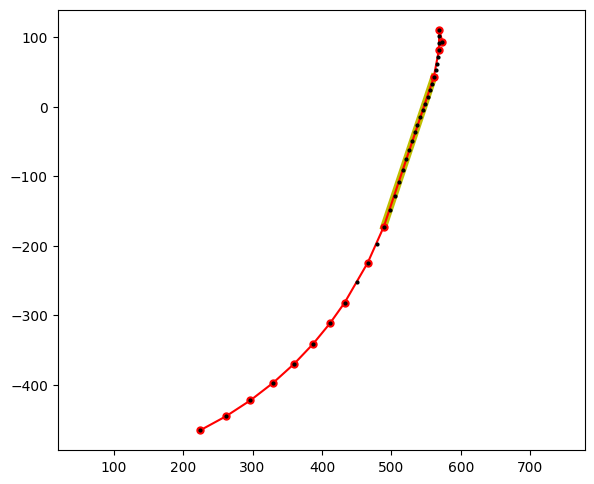

In [23]:
import numpy as np
from numpy import sin, cos, pi
from scipy.optimize import root
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)


#L1, L2, L3, L4, theta5
# dims_0 = [33.90701626, 52.70572024, 47.64062114, 39.56311257,  0.69582653]
# dims_0 = [40.86696359, 58.94079141, 56.63136145, 43.61973342,  0.71266773]
# dims_0 = [31.49165768, 49.99185716, 38.80310215, 43.70066141, -0.2441217 ]
# dims_0 = [32.51951006, 49.95192839, 40.09426508, 42.3469301 , -0.0244356 ]
# dims_0 = [32.16050325, 49.71386295, 40.89005164, 41.03462869,  0.22314399]
# dims_0 = [32.67419479, 49.99971777, 41.60962176, 41.08057512,  0.25414072]
dims_0 = [32.67308165, 49.99972578, 41.58894135, 41.09978546,  0.24911804]
# dims_0 = (29, 49, 39, 40, 0)
L5 = 500
npts = 50
epsilon_0 = 1
TR_cutoff_0 = 42
guess_0 = np.array([-0.37, 0.93, 0.47, -0.88]) #almost 400mm test stand 


def douglas_peucker(points, epsilon):
    if len(points) <= 2:
        return points
    
    dmax = 0
    index = 0
    
    for i in range(1, len(points) - 1):
        d = np.abs(np.cross(points[-1] - points[0], points[i] - points[0])) / np.linalg.norm(points[-1] - points[0])
        if d > dmax:
            index = i
            dmax = d
    
    if dmax > epsilon:
        recursive_result1 = douglas_peucker(points[:index + 1], epsilon)
        recursive_result2 = douglas_peucker(points[index:], epsilon)
        return np.concatenate((recursive_result1[:-1], recursive_result2))
    else:
        return np.array([points[0], points[-1]])
    
def get_endpt(dims, theta1, guess):
    L1, L2, L3, L4, theta5 = dims
    sin5 = sin(theta5)
    cos5 = cos(theta5)

    sin1 = sin(theta1)
    cos1 = cos(theta1) 
    def func_sincos(vars):
        sin2, cos2, sin3, cos3 = vars
        return [
            L1*sin1 + L2*sin2 + L3*sin3,
            L1*cos1 + L2*cos2 + L3*cos3 - L4, 
            sin2**2 + cos2**2 - 1,
            sin3**2 + cos3**2 - 1,        
        ]
    def jac_sincos(vars):
        sin2, cos2, sin3, cos3 = vars
        return [
            [L2, 0, L3, 0],
            [0, L2, 0, L3],
            [2*sin2, 2*cos2, 0, 0],
            [0, 0, 2*sin3, 2*cos3]
        ]
    
    sol = root(func_sincos, jac=jac_sincos, x0=guess, method='hybr').x
    sin2, cos2, sin3, cos3 = sol
    guess = sol

    p5 = L1*np.array([cos1, sin1]) + L2*np.array([cos2, sin2]) + L5*np.array([cos2*cos5-sin2*sin5, sin2*cos5+cos2*sin5])
    return p5, sol

def cost(dims, guess, npts=50, TR_cutoff=TR_cutoff_0, epsilon=epsilon_0):
    theta1_range = np.linspace(0, 2*pi, npts)
    path = []

    for theta1 in theta1_range:
        p5, sol = get_endpt(dims, theta1, guess)
        guess = sol
        path.append(p5)

    start_i = int(npts/2)
    end_i = int(npts/2)

    last_p5 = path[start_i]
    while start_i > 0:
        p5 = path[start_i]
        if np.linalg.norm(p5 - last_p5) > TR_cutoff:
            break
        last_p5 = p5
        start_i -= 1

    last_p5 = path[end_i]
    while end_i < npts:
        p5 = path[end_i]
        if np.linalg.norm(p5 - last_p5) > TR_cutoff:
            break
        last_p5 = p5
        end_i += 1

    path = np.array(path[start_i:end_i])
    path_simp = douglas_peucker(path, epsilon)

    max_length = 0
    for i in range(len(path_simp) - 1):
        segment_length = np.linalg.norm(path_simp[i] - path_simp[i + 1])
        max_length = max(segment_length, max_length)
    
    return max_length, path, path_simp

max_length, path, path_simp = cost(dims_0, guess_0)

def longest_segment_length(points):
    max_length = 0
    max_indexes = (0, 0)
    for i in range(len(points) - 1):
        segment_length = np.linalg.norm(points[i] - points[i + 1])
        if segment_length > max_length:
            max_length = segment_length
            max_indexes = (i, i+1)
    return max_length, max_indexes
max_length2, max_indexes = longest_segment_length(path_simp)

print("maxlen: ", max_length, max_length2)


plt.close()
fig = plt.figure(figsize=(6,5))
ax = fig.subplots(1, 1)
fig.tight_layout()
ax.axis('equal')


# max_pts.set_data((, ))
max_pts, = ax.plot(path_simp[max_indexes[0]:max_indexes[1]+1,0], path_simp[max_indexes[0]:max_indexes[1]+1,1], 'y-', linewidth=5)
simp_pts, = ax.plot(path_simp[:,0], path_simp[:,1], 'ro-', markersize=5)
path_pts, = ax.plot(path[:,0], path[:,1], 'ko', markersize=2)